# ECOSTRESS LST Geolocation Correction using Sentinel-2 Water Masks at 70 meter Resolution

Date: 02/26/2025

Notebook: Andrew Alamillo, Jet Propulsion Laboratory, California Institute of Technology, Pasadena, California, USA
Acknowledgements: The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004) © 2025. California Institute of Technology. Government sponsorship acknowledged.



Contact: aalamillo619@gmail.com and madeleine.a.pascolini-campbell@jpl.nasa.gov

### Where to Obtain ECOSTRESS Data?

ECOSTRESS Data is obtainable on [Appeears](https://appeears.earthdatacloud.nasa.gov/task/area) which requires an account to request images. Please refer to JPL's [ECOSTRESS Tutorials Github]((https://github.com/ECOSTRESS-Tutorials)) for guides on setting up your account and downloading data. This code primarily works best with Collection 2 data as Collection 2 provides personalized water masks for each scene. Appeears provides each of the three files to their own bounding box based on the users Region of Interest (ROI). 

### Necessary Files
- Land Surface Temperature (LST)
- Quality Control (QC)
- Water Mask

### Optional Files
- Cloud Mask (CM)

### ECOSTRESS Geolocation Accuracy

The ECOSTRESS sensor aboard the International Space Station (ISS) does not have pinpoint geolocation accuracy. The ECOSTRESS team at NASA JPL have alogrithms to match scenes to their correct location using ground truth points, however there are still some scenes that have a geolocation error of up to 7 kilometers. Scenes along the coast or near a body of water tend to have notable geolocation errors. 

### What is this Code's Approach?

This code aims to match the ECOSTRESS LST shorelines with the ECOSTRESS water mask. The ECOSTRESS water mask is based on Sentinel-2 Data, which has higher geolocation accuracy, and has been resized to ECOSTRESS's 70 meter pixel resolution.

#### Edge Detection
The main process to detect the shorelines is by using canny edge detection via python's skimage package. Visually, it is clear in most images where the shoreline of an image should go based on the color gradient and image values. Before edge detection is conducted, the image will have a gaussian blur applied to aid in identifying strong pixel differences and also by reducing noise. Skimage canny edge detection identifies the most significant changes in values between pixels based on the **gradient magnitude**. The Gradient magnitude is calculated by obtaining the Sobel kernels for the x and y directions, obtaining the product between the image and sobel kernals and finally applying the pythagorean theorum using the resulting products. This process is shown below


##### 
<div style="display: flex; justify-content: space-between; width: 100%; font-size: 1em;">
  <span style="flex: 1; text-align: left;">Sobel Kernels</span>
</div>

$$
G_x = \begin{bmatrix} 
-1 & 0 & 1 \\ 
-2 & 0 & 2 \\ 
-1 & 0 & 1 
\end{bmatrix}
$$

$$
G_y = \begin{bmatrix} 
1 & 2 & 1 \\ 
0 & 0 & 0 \\ 
-1 & -2 & -1 
\end{bmatrix}
$$


##### 
<div style="display: flex; justify-content: space-between; width: 100%; font-size: 1em;">
  <span style="flex: 1; text-align: left;">Compute Gradients</span>
</div>

$$
I_x = Image * G_x
\hspace{1cm}
I_y = Image * G_y
$$


##### 
<div style="display: flex; justify-content: space-between; width: 100%; font-size: 1em;">
  <span style="flex: 1; text-align: left;">Gradient Magnitude</span>
</div>

$$
|G| = \sqrt{I_x^2 + I_y^2}
$$


#### Edge Alignment
There is a process of hysteresis thresholding allowing for edges based on if the gradient value is either under, between, or above two distinct thresholds . This step is in development, as each image requires unique thresholds to isolate the LST shoreline. For this current version, no low or high thresholds will be set which will result in unwanted edges.

After Edge Detection is computed the LST image, the edges go through a process of filtering to remove some unwanted edges. After edge filtration, the _best_ edges are clipped by their own extended bounding box. The bounding box is expanded by 100 pixels in the x and y direction to mimic the 7km error. This bounding box will be used to clip the isolated ECOSTRESS edge and the associated Water Mask image. By rolling the ECOSTRESS image along the Water Mask, the best overlapping position is found and the shfit is stored for calculation. For large scenes with multiple isloated shorelines, like Hawaii, each shoreline will be calculated individually. The final shift for every shoreline will be stored and used to find the best overall shift for the entire image. 


### Potential Errors
This geolocation code is a tool to _help_ researchers shift ECOSTRESS LST images to a potentially  _correct_ position. Multiple factors could attribute to errors with finding the correct shift using this code. Some of these issues include:
- Warping
- Noisy scenes
- Cloudy scenes
- Image Striping
- Watermask quality (Empty segments)


In [1]:
# Import Cell for Required Modules
import os
import numpy as np
import cv2
from osgeo import gdal
from scipy.ndimage import binary_hit_or_miss
from skimage import feature, morphology, measure
from pandas import DataFrame
from matplotlib import pyplot as plt

## GDAL Exceptions ###

Versions of GDAL before GDAL 4.0 do not have exceptions on be default. These two lines will raise errors from GDAL when encountered and will suppress them. When GDAL 4.0 is released, exceptions will be set to on be default.

In [2]:
gdal.UseExceptions()
gdal.PushErrorHandler('CPLQuietErrorHandler')

0

In [ ]:
# Functions Cell
def Clip_Parent_Water_Mask(Parent_Image, Temp_Eco_File, Temp_Water_File, Temp_QC_File, Temp_Cloud_File):
    # Open the parent image and get its image specs
    Parent_Image = gdal.Open(Parent_Image)
    ref_x_min, ref_x_res, _, ref_y_max, _, ref_y_res = Parent_Image.GetGeoTransform()
    ref_width = Parent_Image.RasterXSize
    ref_height = Parent_Image.RasterYSize
    ref_x_max = ref_x_min + ref_x_res * ref_width
    ref_y_min = ref_y_max + ref_y_res * ref_height

    Eco_Aligned = np.zeros((ref_height, ref_width)) # Making duplicate zero Parent_images to keep image sizes the same
    Water_Aligned = np.zeros((ref_height, ref_width))
    QC_Aligned = np.zeros((ref_height, ref_width))
    Cloud_Aligned = np.zeros((ref_height, ref_width))

    Temp_Eco = gdal.Open(Temp_Eco_File) # Get current image values to match with the Parent WM
    temp_x_min, temp_x_res, _, temp_y_max, _, temp_y_res = Temp_Eco.GetGeoTransform()
    temp_width = Temp_Eco.RasterXSize
    temp_height = Temp_Eco.RasterYSize
    temp_x_max = temp_x_min + temp_x_res * temp_width
    temp_y_min = temp_y_max + temp_y_res * temp_height

    Temp_Water = gdal.Open(Temp_Water_File)
    Temp_QC = gdal.Open(Temp_QC_File)
    if os.path.exists(Temp_Cloud_File):
        Temp_Cloud = gdal.Open(Temp_Cloud_File)

    overlap_x_min = max(ref_x_min, temp_x_min) # Get the area of the overlapping segments between the temp eco file and the parent WM
    overlap_y_min = max(ref_y_min, temp_y_min)
    overlap_x_max = min(ref_x_max, temp_x_max)
    overlap_y_max = min(ref_y_max, temp_y_max)

    TL_x_parent = int((overlap_x_min - ref_x_min) / ref_x_res) # Calculate the top left and bottom right coordinates of the overlapped region for parent using parent resolution
    TL_y_parent = int((ref_y_max - overlap_y_max) / abs(ref_y_res))
    BR_x_parent = int((overlap_x_max - ref_x_min) / ref_x_res)
    BR_y_parent = int((ref_y_max - overlap_y_min) / abs(ref_y_res))

    cols_parent = BR_x_parent - TL_x_parent
    rows_parent = BR_y_parent - TL_y_parent

    
    if cols_parent <= 0 or rows_parent <= 0: # If statement to check if the temp scene is within the parent WM
        raise ValueError("Images do not overlap")

    # Calculate the offset and number of pixels to read from the temp images
    TL_x_temp = int((overlap_x_min - temp_x_min) / temp_x_res) # Calculate the top left and bottom right coordinates of the overlapped region for temp images using temps resolution
    TL_y_temp = int((temp_y_max - overlap_y_max) / abs(temp_y_res))
    BR_x_temp = int((overlap_x_max - temp_x_min) / temp_x_res)
    BR_y_temp = int((temp_y_max - overlap_y_min) / abs(temp_y_res))

    cols_temp = BR_x_temp - TL_x_temp
    rows_temp = BR_y_temp - TL_y_temp

    if cols_temp <= 0 or rows_temp <= 0: # If statement to check if the temp scene is within the parent WM
        raise ValueError("Images do not overlap")

    Eco_Clip = Temp_Eco.GetRasterBand(1).ReadAsArray(TL_x_temp, TL_y_temp, cols_temp, rows_temp).astype(float) # Reading the temp images from the overlapped segments. This avoids reading any part of the scene that is not needed
    Water_Clip = Temp_Water.GetRasterBand(1).ReadAsArray(TL_x_temp, TL_y_temp, cols_temp, rows_temp)           # This also helps with not taking too much memory
    QC_Clip = Temp_QC.GetRasterBand(1).ReadAsArray(TL_x_temp, TL_y_temp, cols_temp, rows_temp).astype(float) 

    if os.path.exists(Temp_Cloud_File):
        Cloud_Clip = Temp_Cloud.GetRasterBand(1).ReadAsArray(TL_x_temp, TL_y_temp, cols_temp, rows_temp)


    Eco_Aligned[TL_y_parent:BR_y_parent, TL_x_parent:BR_x_parent] = Eco_Clip[:rows_parent, :cols_parent] # Placing the Eco_Clip into the zeroed version of the temp file. This will be the "correct" position in an array
    Water_Aligned[TL_y_parent:BR_y_parent, TL_x_parent:BR_x_parent] = Water_Clip[:rows_parent, :cols_parent]
    QC_Aligned[TL_y_parent:BR_y_parent, TL_x_parent:BR_x_parent] = QC_Clip[:rows_parent, :cols_parent]

    if os.path.exists(Temp_Cloud_File):
        Cloud_Aligned[TL_y_parent:BR_y_parent, TL_x_parent:BR_x_parent] = Cloud_Clip[:rows_parent, :cols_parent]

    Parent_Aligned = Parent_Image.ReadAsArray()
    # Close the datasets
    Parent_Image = None
    Temp_Eco = None
    Temp_Water = None
    Temp_QC = None
    Temp_Cloud = None

    return Eco_Aligned.astype(float), Water_Aligned, QC_Aligned.astype(float), Cloud_Aligned, Parent_Aligned

def Best_Line_Eco(Line_Number, Ref_img, Og_Ref_img, Img_to_Clip,expand,step):
    expand = int(expand)
    
    Reference_Img = np.pad(Ref_img, ((expand, expand), (expand, expand)), mode='constant', constant_values=0)
    
    Image_to_Clip = np.pad(Img_to_Clip, ((expand, expand), (expand, expand)), mode='constant', constant_values=0)

    stats = measure.regionprops_table(Reference_Img,properties=('label','bbox','bbox_area'))
    
    Line_Box_Boundaries = DataFrame(stats)

    Line_Box_Boundaries = Line_Box_Boundaries.sort_values('bbox_area', ascending = False)

    Filter = (Line_Box_Boundaries['bbox_area'] > 1000).to_list()   # Filter the water mask bounding boxes to a 1000 pixels area (T or F)

    Binary_Filter = [1 if x else 0 for x in Filter] # Switched Filter from True or False to binary
  
    Labels = Line_Box_Boundaries['label'].to_list()                

    maxlines = Labels[Line_Number]

    if step == 0:

        Labels = np.multiply(Binary_Filter, Line_Box_Boundaries['label'].to_list())

        Mask = np.isin(Reference_Img, test_elements = Labels)
    else:

        Mask = np.isin(Reference_Img, test_elements = maxlines)

    maxlines = maxlines-1 

    if step == 0:

        # Setting up the extended boundary box for the ECOSTRESS line. 
        Pad_Col_S = int(abs(Line_Box_Boundaries['bbox-0'].min() - expand))
        Pad_Col_E = int(Line_Box_Boundaries['bbox-2'].max() + expand) 
        Pad_Row_S = int(abs(Line_Box_Boundaries['bbox-1'].min() - expand))
        Pad_Row_E = int(Line_Box_Boundaries['bbox-3'].max() + expand)

        Original_Shoreline = np.pad(Og_Ref_img, ((expand, expand), (expand, expand)), mode='constant', constant_values=0)
        
        Mask = Mask[Pad_Col_S:Pad_Col_E, Pad_Row_S:Pad_Row_E]
        
        Clipped_Shoreline = Original_Shoreline[Pad_Col_S:Pad_Col_E, Pad_Row_S:Pad_Row_E]

        Clipped_Reference = Clipped_Shoreline * Mask

        Clipped_ITC = Image_to_Clip[Pad_Col_S:Pad_Col_E, Pad_Row_S:Pad_Row_E]
    
        Clip_Values = (Pad_Col_S,Pad_Col_E, Pad_Row_S,Pad_Row_E)

    if step == 1:
        # Setting up the extended boundary box for the ECOSTRESS line. 
        Pad_Col_S = int(abs(Line_Box_Boundaries.at[maxlines,'bbox-0'] - expand))
        Pad_Col_E = int(Line_Box_Boundaries.at[maxlines,'bbox-2'] + expand) 
        Pad_Row_S = int(abs(Line_Box_Boundaries.at[maxlines,'bbox-1'] - expand))
        Pad_Row_E = int(Line_Box_Boundaries.at[maxlines,'bbox-3'] + expand)

        Clipped_Reference = np.clip(Mask[Pad_Col_S:Pad_Col_E,Pad_Row_S:Pad_Row_E],a_min=0, a_max=1)

        Clipped_ITC = np.clip(Image_to_Clip[Pad_Col_S:Pad_Col_E,Pad_Row_S:Pad_Row_E],a_min=0, a_max=1) # ITC is Image to Clip

        Clip_Values = (Pad_Col_S,Pad_Col_E, Pad_Row_S,Pad_Row_E)

    Col_length = Line_Box_Boundaries.at[maxlines,'bbox-1']

    Row_length = Line_Box_Boundaries.at[maxlines,'bbox-3']

    return Clipped_Reference, Clipped_ITC, Clip_Values,Col_length, Row_length,maxlines

def Sorted_Longest_Lines(img):
    Labeled_Img = measure.label(img, connectivity = 2)
    
    Labeled_Table = measure.regionprops_table(Labeled_Img, properties=('label','bbox','bbox_area'))

    Labeled_Table = DataFrame(Labeled_Table)

    Line_Lengths = []

    for i in range(1, Labeled_Table.shape[0]+1):
        count = np.count_nonzero(Labeled_Img == i)
        Line_Lengths.append(count)

    Labeled_Table.insert(6, "Line_Length", Line_Lengths, True)

    Sorted_Table = Labeled_Table.sort_values('Line_Length', ascending = False)
    
    return Sorted_Table, Labeled_Img

def End_Points(img):

    Skeleton_ECOSTRESS = (morphology.skeletonize(img)).astype(np.uint8)
    
    directions = [
        np.array([[1,0,0],[0,1,0],[0,0,0]]).astype(np.uint8),
        np.array([[0,1,0],[0,1,0],[0,0,0]]).astype(np.uint8),
        np.array([[0,0,1],[0,1,0],[0,0,0]]).astype(np.uint8),
        np.array([[0,0,0],[1,1,0],[0,0,0]]).astype(np.uint8),
        np.array([[0,0,0],[0,1,1],[0,0,0]]).astype(np.uint8),
        np.array([[0,0,0],[0,1,0],[1,0,0]]).astype(np.uint8),
        np.array([[0,0,0],[0,1,0],[0,1,0]]).astype(np.uint8),
        np.array([[0,0,0],[0,1,0],[0,0,1]]).astype(np.uint8)
    ]

    Combined_Results = sum(binary_hit_or_miss(Skeleton_ECOSTRESS, structure1 = EndPoint_Orientation).astype(int) for EndPoint_Orientation in directions)

    endpoint_locations = np.where(Combined_Results == 1)

    EndP_Locations = list(zip(endpoint_locations[0],endpoint_locations[1])) # Row (Y), Column order (X)

    # Some lines are circular and do not have endpoints this section provides a work around to no end points 
    if len(EndP_Locations) == 0:
        Every_ones_Location = np.where(Skeleton_ECOSTRESS == 1)

        Total_Location = list(zip(Every_ones_Location[0],Every_ones_Location[1]))

        EndP_Locations = Total_Location[0]

    return Skeleton_ECOSTRESS, EndP_Locations

def MatchingOverlay(Eco,Water,expand,endpoints):

    if type(endpoints) is list:
        yend_Eco = endpoints[0][0]
        xend_Eco = endpoints[0][1]
    if type(endpoints) is tuple:
        yend_Eco = endpoints[0]
        xend_Eco = endpoints[1]

    Water_Coordinates = np.argwhere(Water == 1)

    xs = []
    ys = []
    
    for i in range(0, len(Water_Coordinates)):
        ys.append(Water_Coordinates[i][0])
        xs.append(Water_Coordinates[i][1])

    # Calculate binary list of all endpoints within 100 pixels

    positions = (xs <= (xend_Eco + expand)) & (xs >= (xend_Eco - expand)) & \
                (ys <= (yend_Eco + expand)) & (ys >= (yend_Eco - expand))

    # Convert binary list to shift coordinates
    Shift_Coordinates = np.column_stack((positions * (xs*positions-xend_Eco), positions * (ys*positions-yend_Eco)))

    # Find rows with exactly two zeros
    mask = np.count_nonzero(Shift_Coordinates, axis=1) == Shift_Coordinates.shape[1] - 2

    filtered_arr = Shift_Coordinates[~mask]

    filtered_arr = np.vstack((filtered_arr,[0,0]))

    [X_Shift, Y_Shift, Eco_Ratio, _, Overlapped_Twos] = Matching_Shift(filtered_arr,Eco,Water)

    return X_Shift, Y_Shift, Eco_Ratio, Overlapped_Twos

def Matching_Shift(Shift_Coordinates,Eco,Water):
    # Initialize variables
    Best_Position = 0
    Best_Index = 0
    Eco_Ratio = 0
    Connected_Twos = []
    
    # Iterate through Shift_Coordinates
    for i in range(len(Shift_Coordinates)):

        Shifted_Image = np.roll(Eco, (Shift_Coordinates[i]),axis = (1,0))

        New_Combined = Shifted_Image + Water

        # Measurement of connected components (Lengths)

        New_Twos = np.count_nonzero(New_Combined == 2)

        if New_Twos > Best_Position:                # New positions
            Best_Position = New_Twos
            Best_Index = i
            Eco_Ratio = New_Twos/ np.count_nonzero(Eco == 1)
            Connected_Twos = New_Combined         

    if Best_Position == 0: # Incase the initial position is best 
        X_Shift = 0
        Y_Shift = 0
        Eco_Ratio = 0
        Connected_Twos = Eco + Water
    else:
        Y_Shift = Shift_Coordinates[Best_Index, 1]
        X_Shift = Shift_Coordinates[Best_Index, 0]

    return X_Shift, Y_Shift, Eco_Ratio, Connected_Twos, Best_Position

## File Selection

There are 3 main files that are necessary for running this code. The three main files are the LST file, Water Mask file, and the QC file. There is an option for a cloud mask if it is available in the same folder the LST file is in. Once the file names are identified, they are opened to their respective matrix names.

In [ ]:
## --------------------------- Customizable Variables & Supplementary Files ---------------------------
## Specifiy single scene calculation - Jupyter Notebook Version only 

Folder = os.getcwd()  # Replace this file path with the folder path containing your ECOSTRESS files 

lst_name = 'LST_FILE_NAME' # Desired LST filename

Parent_Water_Mask = 'None' # Change 'None' to your desired water mask image
                           # please make sure your water mask is in the same projection as the ECOSTRESS data

qc_name = lst_name.replace('_LST_', '_QC_')

c_name = lst_name.replace('_LST_', '_cloud_mask_')

wm_name = lst_name.replace('_LST_','_water_')

wm_check = os.path.join(Folder, wm_name) 

if os.path.exists(wm_check) == False: # C2 LST Swath water mask uses "_water_mask_" while C2 LST Tiled simply contains "_water_"

    wm_name = lst_name.replace('_LST_', '_water_mask_')   

## --------------------------- Constructing File name strings ---------------------------

EcoFile = os.path.join(Folder, lst_name)

QCFile = os.path.join(Folder, qc_name) 

WaterFile = os.path.join(Folder,wm_name)

CloudFile = os.path.join(Folder, c_name)

## --------------------------- Check if the Parent Water Mask will be used ---------------------------
if os.path.exists(Parent_Water_Mask) == False:
    ## --------------------------- Opening Rasters ---------------------------
    Eco = gdal.Open(EcoFile).ReadAsArray().astype(float)               

    Water = gdal.Open(WaterFile).ReadAsArray()

    QC = gdal.Open(QCFile).ReadAsArray().astype(float)

    if os.path.exists(CloudFile) == True:
        Cloud = gdal.Open(CloudFile).ReadAsArray()

    Eco[Eco == 0] = np.nan  # NaNs help with visualization in figures

    print('Shift correction will be ran for ', lst_name, 'using personalized water mask')

if os.path.exists(Parent_Water_Mask) == True:
    ## --------------------------- Opening Rasters and Clip to Parent WM ---------------------------
    Eco, _, QC, Cloud, Water = Clip_Parent_Water_Mask(Parent_Water_Mask, EcoFile, WaterFile, QCFile, CloudFile)

    Eco[Eco == 0] = np.nan  # NaNs help with visualization in figures

    print('Shift correction will be ran for ', lst_name, 'using parent water mask')



c:\Users\alamillo\Desktop\Jupyter_Files\Jupyter_Test2\Jupyter_Test\ECO_L2T_LSTE.002_water_doy2023012222450_aid0001_30N.tif
Shift correction will be ran for  ECO_L2T_LSTE.002_LST_doy2023012222450_aid0001_30N.tif using parent water mask


## Water Mask Processing

The ECOSTRESS LST and Water Mask images could be clipped to the bounding box of the water mask coastline to help with processing times.Obtaining the coastline from the water mask is essential however, obtaining the shoreline leads to an unwanted iamge boundary which will  be an issue to when matching the overlapping LST shorelines. The QC file will be used to remove the edges based on the data quality . The QC file will be converted into a binary mask and eroded by a few pixels and later masked onto the water file to remove the edge.

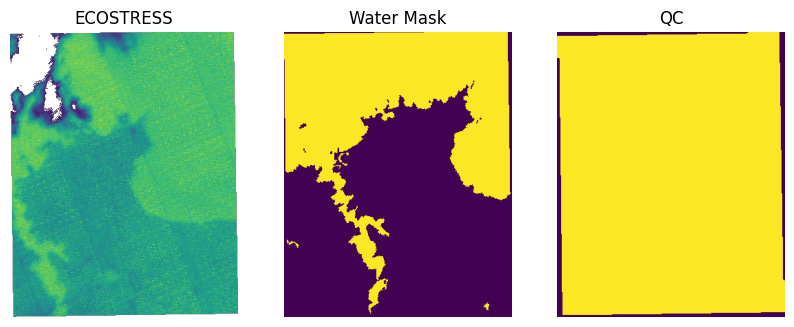

Edges along the border of the image have been removed in the "Water Mask Edges" image


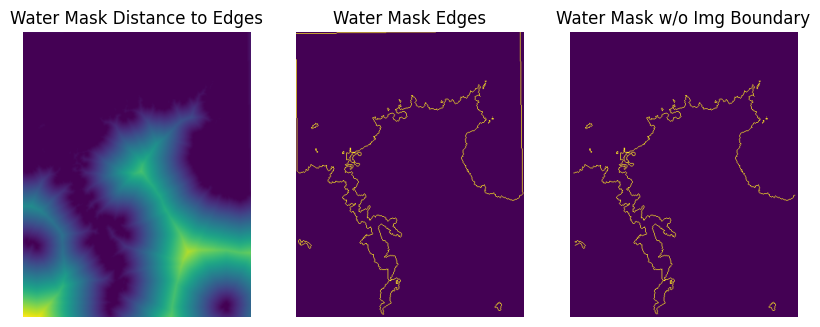

In [6]:
## -------------------------Determining Acceptable Edges from QC File -------------------------

Accetable_Values_Area = ((QC != -99999) & (QC != 65535) & (QC != 0)).astype(np.uint8)

Erase = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6)).astype(np.uint8)

Eroded_QC = cv2.erode(src = Accetable_Values_Area, kernel = Erase).astype(np.uint8)

Eroded_QC =  Eroded_QC.astype(np.uint8) # Eroded_QC will be used to remove the water mask border edges for large swath images. 

## --------------------------- Removing Image Edges Detected in Water Mask ---------------------------

Water[Water == 255] = 0 # 0 over NaN due to desired edge detection

Inverse_Water = cv2.bitwise_not((Water * 255)).astype(np.uint8)

Inverse_Water_255 = (Inverse_Water * 255).astype(np.uint8)

Inverse_dist_transform_water = cv2.distanceTransform(src = Inverse_Water_255, distanceType =  cv2.DIST_L2, maskSize = 5)                     

Distance_to_Edge = Inverse_dist_transform_water == 1

Inverse_Accetable_Values_Area = (Distance_to_Edge).astype(np.uint8) * Eroded_QC # Pixels with values of 1 are the shoreline of the water mask.
                                                                                # Applying the Eroded_QC removes the image edges that are not needed for calculation

test1 = np.unique(Inverse_Accetable_Values_Area)

test2 = list(test1[1:])       # Removes 0 from the unique values

## --------------------------- Display images ---------------------------

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs[0].imshow(Eco)
axs[0].set_title('ECOSTRESS')
axs[0].axis('off')  # Hide axes
axs[1].imshow(Water)
axs[1].set_title('Water Mask')
axs[1].axis('off')
axs[2].imshow(Eroded_QC)
axs[2].set_title('QC')
axs[2].axis('off')
plt.show()

print('Edges along the border of the image have been removed in the "Water Mask Edges" image')

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs[0].imshow(Inverse_dist_transform_water)
axs[0].set_title('Water Mask Distance to Edges')
axs[0].axis('off')
axs[1].imshow((Inverse_dist_transform_water == 1))
axs[1].set_title('Water Mask Edges')
axs[1].axis('off')
axs[2].imshow(Inverse_Accetable_Values_Area)
axs[2].set_title('Water Mask w/o Img Boundary')
axs[2].axis('off')

plt.show()

## Cloud Masking

If possible, the code will apply a cloud mask to the LST image and water mask. The LST cloud masking could help in filtering edges detected by clouds. Although the edges of the water mask cannot be directly clipped by the cloud mask based on georeferencing inconsistencies, the code will find the edges of the clouds and erode them by 100 pixels. This eroded cloud mask will only clip out segments of the water mask that are covered by clouds. This step is not vital to image matching and will remain optional unless provided with a cloud mask file.

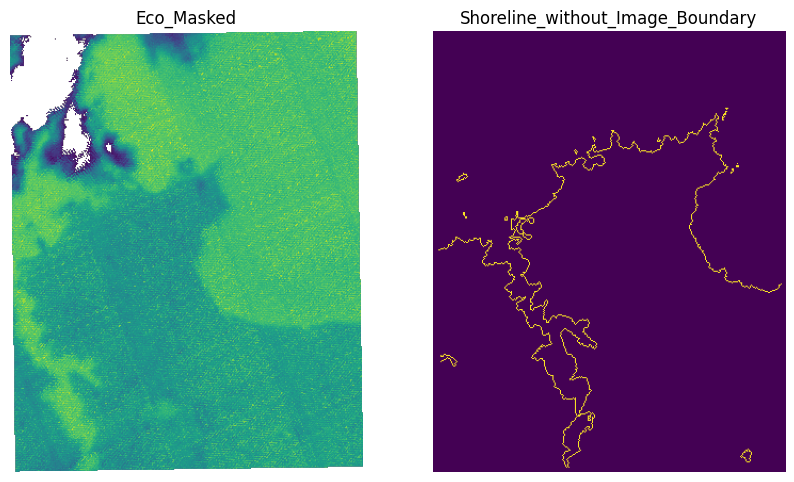

In [7]:
##  ------------------------- Applying Cloud Mask to Ecostress and Watermask (if possible) -------------------------
if os.path.exists(CloudFile) == True:
    
    Cloud_255 = (Cloud * 255).astype(np.uint8)

    dist_transform = cv2.distanceTransform(Cloud_255, cv2.DIST_L2, 5)

    dist = 5

    _, Small_Cloud_Edge_Dilate = cv2.threshold(dist_transform,dist,255, cv2.THRESH_BINARY) # A radius of 5 ensures edges based on the clouds are still used with edge detection. Set values to 255 for bitwise inversion.

    Small_Cloud_Edge_Dilate = cv2.bitwise_not(Small_Cloud_Edge_Dilate.astype(np.uint8)) 

    Eco_Masked = Eco * Small_Cloud_Edge_Dilate

    Eco_Masked[Eco_Masked == 0] = np.nan  # cleaning up Eco_Masked 0's

    ## ------------------------- Cloud Buffer Water Mask Application  -------------------------
    dist2 = 100

    _, Cloud_Edge_Eroded = cv2.threshold(dist_transform,dist2,255, cv2.THRESH_BINARY)

    Cloud_Edge_Eroded = cv2.bitwise_not(Cloud_Edge_Eroded.astype(np.uint8)) / 255

    Shoreline_without_Image_Boundary = Inverse_Accetable_Values_Area * Cloud_Edge_Eroded

    Shoreline_without_Image_Boundary[Shoreline_without_Image_Boundary == 0] = 0  # cleaning up Eco_Masked 0's
else:
    Eco_Masked = Eco

    Eco_Masked[Eco_Masked == 0] = np.nan  # cleaning up Eco_Masked 0's
    
    Shoreline_without_Image_Boundary = Inverse_Accetable_Values_Area

## --------------------------- Display images ---------------------------

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(Eco_Masked)
axs[0].set_title('Eco_Masked')
axs[0].axis('off')  # Hide axes
axs[1].imshow(Shoreline_without_Image_Boundary)
axs[1].set_title('Shoreline_without_Image_Boundary')
axs[1].axis('off')

plt.show()

## Image Cropping and Preliminary Line Selection

Clipping the LST and Water Mask image to the smallest bounding box containing every shore within the water mask will help with computation times. For example, a swath image over an island should only focus on the area around the island instead of the ocean. After clipping both images, a binary mask of a dilated watermask coastline with a 100 pixel radius will be applied to the LST image. This dilated coastline mask represents the 7km error "max" error that is generally seen for incorrect geolocations. 

Canny edge detection with a blurring effect will be applied to the LST image due to noise. There will be no threshold limits for the LST image as every image will have a unique threshold values that could isolate the shoreline. Identifying universal thresholds is tricky and instead will use a threshold of 0. Using a value of 0 will provide every possible detected edge. In order to reduce the number of lines, a higher blur is applied to the LST image. The high blur reduces the accuracy of the shoreline in the LST image but will be used to find overlapping values between the Initial Canny LST and the Higher Blurred Canny LST. The Initial Canny LST lines which overlapped with the Higher Blurred Canny LST will be used for edge matching with the water mask. 

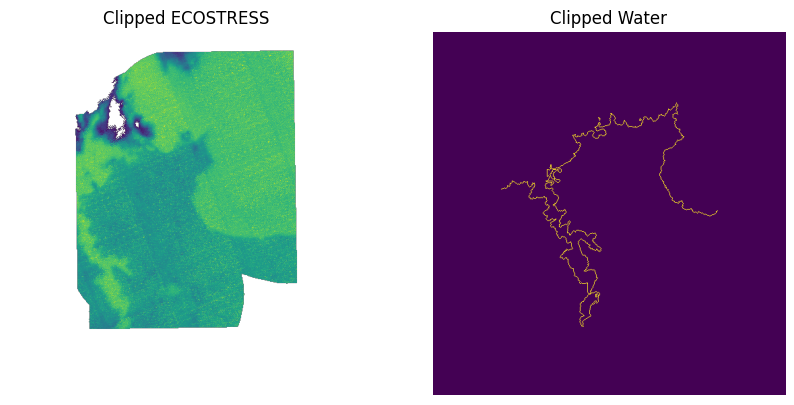

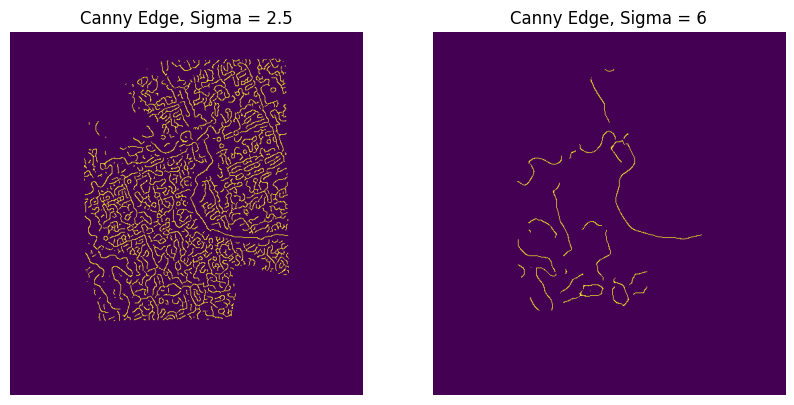

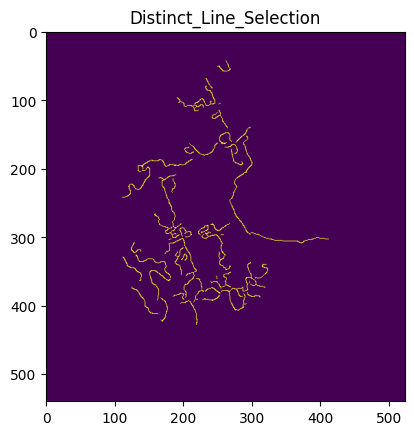

In [8]:
## --------------------------- Identifying the Longest Shoreline ---------------------------

Connecting_Shoreline = morphology.binary_dilation(Shoreline_without_Image_Boundary).astype(np.uint8) # Increases thickness of lines to connect any disconnected lines

_,Mapped_Lines = cv2.connectedComponents(Connecting_Shoreline, connectivity = 8)

[Clip_Water, Clip_Eco,_, _,_,_] = Best_Line_Eco(0, Mapped_Lines,Shoreline_without_Image_Boundary, Eco_Masked,100,0) # Clips both Water and ECOSTRESS image to the longest Shoreline

_,Mapped_Lines2,stats,_ = cv2.connectedComponentsWithStats(Clip_Water.astype(np.uint8), connectivity = 8)

Shore_lengths = stats[: ,cv2.CC_STAT_AREA]

sorted_indecies = np.argsort(-Shore_lengths)

Blank = np.array([[0,0],[0,0]]).astype(np.uint8)  # This "Blank" variable is needed to avoid an optional route in the custom Best_Line_Eco formula

Main_Matching_Stats = []

Clip_Eco[Clip_Eco == 0] = np.nan

## --------------------------- ECOSTRESS Edge Area Clip ---------------------------             

Water_Buffer = morphology.isotropic_dilation(Clip_Water,radius = 100)   # Applied a 100 radius buffer to Clip_Water representing the area a possible shift is possible

Clip_Eco[~Water_Buffer] = np.nan                                        # Applies mask from Water Buffer (removes any non accetable shift option)

## --------------------------- ECOSTRESS Edge Detection and Line Selections ---------------------------

Initial_Canny =  feature.canny(Clip_Eco,sigma=2.5)  # This value can be changed for certain LST images. Sigma = 2 is a good balance between

High_Blur_Canny =  feature.canny(Clip_Eco,sigma=6)  # Higher order edge used to simplify image-to-match  

Labeled_Edges = measure.label(Initial_Canny, connectivity = 2) # Gives an index to each binary line

Overlapping_Lines = Labeled_Edges * High_Blur_Canny   # Keeps lines that overlap between the heavily blurred lines and the intial canny. Heavy blurred lines have reduce shoreline accuracy

Distinct_Line_Nums = np.unique(Overlapping_Lines)        # Isolates values that overlapped in Overlapiping_LinesHigh_Edge_Clip

Distinct_Line_Nums = list(Distinct_Line_Nums[1:])       # Removes 0 from the unique values

Distinct_Line_Selection = np.isin(Labeled_Edges, test_elements = Distinct_Line_Nums) # Uses the overlapped indexes to filter the clipped canny edges

## --------------------------- Display images ---------------------------

fig, axs = plt.subplots(1, 2, figsize=(10, 10))         
axs[0].imshow(Clip_Eco)
axs[0].set_title('Clipped ECOSTRESS')
axs[0].axis('off') 
axs[1].imshow(Clip_Water)
axs[1].set_title('Clipped Water')
axs[1].axis('off')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(Initial_Canny)
axs[0].set_title('Canny Edge, Sigma = 2.5')
axs[0].axis('off') 
axs[1].imshow(High_Blur_Canny)
axs[1].set_title('Canny Edge, Sigma = 6')
axs[1].axis('off')
plt.show()

plt.figure()
plt.imshow(Distinct_Line_Selection)
plt.title('Distinct_Line_Selection')
plt.show()


## Acquiring Possible Shifts

Each shifting process will be conducted on each isolated shoreline within the water mask by clipping both the water mask and LST images to the bounding box of the isolated shoreline. This process was implemented due the possibility of the total shoreline being split by either the ROI bounding box, Clouds, or segmented by islands. 

And extra step in this process is shoreline length comparison between the top two lines. In large clear scenes, large shorelines could provide a strong edge match to its water mask. In this case the code will determine if a single shift calculation is needed for the specific scene. This is normally for large scenes and will otherwise select only the top 100 longest lines for the analysis. 

Before any sorting is conducted, each line will be clipped to its line's bounding box. In this step each line will have its own shift analysis to its clipped water mask counterpart. The top right most endpoint of the LST edge will be used as the centroid of a new bounding box. This new bounding box, similar to the 100 pixel buffer, will represent the range of water mask pixels that can represent the correct shift. Any values outside of this spot will not be considered. The LST line will travel along the water mask line and will remember the best overlapping position out of all possible locations. This process will only be conducted on the lines that have less than 10 endpoints, eliminating clustered lines. The calculated shift for each acceptable line is stored into a list that will be used for final shift testing. 

In [ ]:
## --------------------------- Selection of Top ECOSTRESS Edges  --------------------------
for Labeled_line in sorted_indecies:
    if Labeled_line == 0:
        continue

    Isolated_Shore = (Mapped_Lines2 == Labeled_line).astype(np.uint8)

    [Indv_Water_Line, Indv_Eco_Line,_, _,_,_] = Best_Line_Eco(0, Isolated_Shore,Blank, Distinct_Line_Selection ,100,1)

    Sorted_Table, Labeled_ECOSTRESS_Image = Sorted_Longest_Lines(Indv_Eco_Line)

    Top_2 = Sorted_Table.iloc[:2, -1].values

    if Top_2.size < 2:
        print("Shift aborted due to limited LST Shores \n")
        continue

    First_Row = Top_2[0]
    Second_Row = Top_2[1]

    # Sorted Line selections will get shorter based on the longest identified area containing the longest line. Doing so reduces computation times

    if First_Row >= (Second_Row * 2) and First_Row >=50000:
        Index_values = ((Sorted_Table.head(5))['label']).to_list()    # Store the labels of the top 5 longest lines
    else:
        Index_values = ((Sorted_Table.head(100))['label']).to_list()    # Store the labels of the top 100 longest lines

    Sorted_Lines_Map = np.isin(Labeled_ECOSTRESS_Image, test_elements = Index_values) # Returns a binary image

    Newly_Labeled = measure.label(Sorted_Lines_Map, connectivity = 2) # Labeled again to begin a new analysis from the binary Sorted_Lines_Map

    Temp_Matching_Stats = []
    ## --------------------------- Acquiring Eligable Shifts --------------------------- 

    for i in range(0, len(Index_values)):
        [Eco_Line, Water_Line,_, Col_length, Row_length,Actual_Index] = Best_Line_Eco(i,Newly_Labeled,Blank,Indv_Water_Line,100,1)

        Skeleton_image, Endpoints = End_Points(Eco_Line) 
        
        if len(Endpoints) <=6: 

            Skeleton_image = morphology.isotropic_dilation(Skeleton_image, radius = 1)

            [Col_Shift,Row_Shift, Ratio,_] = MatchingOverlay(Skeleton_image, Water_Line, 100 , Endpoints)

            Temp_Matching_Stats.append([Col_Shift, Row_Shift, (Ratio*Ratio)*Col_length*Row_length,(Actual_Index+1)]) # The "+ 1" was needed to correct the line's index value to its labeled value
        else: 
            pass
    
## --------------------------- Shift Check for Combined Top Lines --------------------------- 
    Temp_Sorted_Matching_Stats = sorted(Temp_Matching_Stats, key=lambda x:x[2], reverse=True)

    Temp_X_Shifts = [i[0] for i in Temp_Sorted_Matching_Stats]
    Temp_Y_Shifts = [i[1] for i in Temp_Sorted_Matching_Stats]
    Temp_Best_Indexes = [i[3] for i in Temp_Sorted_Matching_Stats]

    Temp_Shift_Coordinates = np.column_stack((Temp_X_Shifts,Temp_Y_Shifts))

    Temp_Top_Lines = np.isin(Newly_Labeled, test_elements = Temp_Best_Indexes)

    Temp_Buffered_Lines = morphology.isotropic_dilation(Temp_Top_Lines, radius = 1)

    [Temp_X_Shift, Temp_Y_Shift, _ ,_, _] = Matching_Shift(Temp_Shift_Coordinates,Temp_Buffered_Lines,Indv_Water_Line)

    Main_Matching_Stats.append([Temp_X_Shift,Temp_Y_Shift])  
    
    # ## -------------------- Visual Representation (Demo Only) --------------------  
    #
    # Comment: 
    #          This visual representation can be activated however this will print 4 images PER line. Most of the lines analyized 
    #          are not significant. If you wish to observe how each line is shifted than feel free to remove the comments (#) and run 
    #          it for a few scenes and interupt the code by using the "square" stop button on the top left of this cell.
    #
    # Image = np.roll(Eco_Line, (Col_Shift, Row_Shift), axis=(1, 0))

    # Combined = Image + Water_Line

    # fig, axs = plt.subplots(1, 4, figsize=(10, 10))
    # axs[0].imshow(Eco_Line)
    # axs[0].set_title('LST Image')
    # axs[0].axis('off') 
    # axs[1].imshow(Water_Line)
    # axs[1].set_title('WaterShifted Image')
    # axs[1].axis('off')
    # axs[2].imshow(Combined)
    # axs[2].set_title('Combined Image')
    # axs[2].axis('off')
    # axs[3].imshow(Combined2)
    # axs[3].set_title('Rolled Combined Image')
    # axs[3].axis('off')
    # plt.show()


    




## Final Shift Test 

The final shifts calculated from the water mask sorted lines are now applied to the total distinct lines selected from the ECOSTRESS image. This is the final edge calculation process to ensure which of the previsouly calculated shifts are the best for the entire scene.  

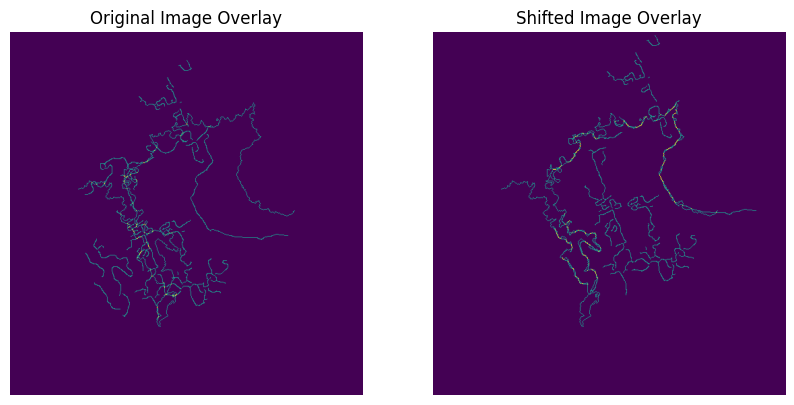

Final Shift
x-shift is 67 

y-shift is -37 



In [10]:
# --------------------------- Testing X and Y Shifts ---------------------------
Main_X_Shifts = [i[0] for i in Main_Matching_Stats]
Main_Y_Shifts = [i[1] for i in Main_Matching_Stats]

Main_Buffered_Lines = morphology.isotropic_dilation(Distinct_Line_Selection, radius = 1)

Main_Shift_Coordinates = np.column_stack((Main_X_Shifts,Main_Y_Shifts))

[Main_X_Shift, Main_Y_Shift, _,_, _] = Matching_Shift(Main_Shift_Coordinates,Main_Buffered_Lines,Clip_Water)

## -------------------- Visual Representation (Demo Only) --------------------  

Shifted_Image = np.roll(Distinct_Line_Selection, (Main_X_Shift,Main_Y_Shift),axis = (1,0))

Pre_Shifted = Distinct_Line_Selection + Clip_Water

Total_Image = Shifted_Image + Clip_Water 

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(Pre_Shifted)
axs[0].set_title('Original Image Overlay')
axs[0].axis('off') 
axs[1].imshow(Total_Image)
axs[1].set_title('Shifted Image Overlay')
axs[1].axis('off')

plt.show()

print('Final Shift')
print(f'x-shift is {Main_X_Shift} \n')
print(f'y-shift is {Main_Y_Shift} \n')





## Applying the Shift

The shift is applied to a copy of the original LST file and is stored in the "Shifted_Folder" folder and with "Shifted_" added to the file name.

In [11]:
# # Commented out is default to avoid the creation of new files. 

# New_Folder = Folder + "Shift_Folder/" 

# if not os.path.exists(New_Folder):                      # Checks the existance of the shifted folder
#     os.mkdir(New_Folder)                                # Writes a new folder if existance is false


# # Applying the shift to a copy of the Original LST
# file_parts = EcoFile.split('/')

# Eco_FileName = next((part for part in file_parts if part.startswith('ECO_L2')), None)

# Eco_Main = gdal.Open(EcoFile)

# driver = gdal.GetDriverByName('GTiff')

# New_Name = os.path.join(New_Folder, 'Shifted_' + Eco_FileName) 

# New_File = driver.CreateCopy(New_Name, Eco_Main, strict = 0)
# New_File = None

# Shift_File = gdal.Open(New_Name,gdal.GA_Update)

# File_Variables = Shift_File.GetGeoTransform()

# x_tl, x_res, dx_dy, y_tl, dy_dx, y_res = File_Variables

# shift_x = X_Shift * x_res
# shift_y = Y_Shift * y_res

# gt_update = (x_tl + shift_x, x_res, dx_dy, y_tl + shift_y, dy_dx, y_res)

# Shift_File.SetGeoTransform(gt_update)

# Shift_File.FlushCache()

# ## --------------------------- Closing gdal open rasters ---------------------------
# Eco = None
# Water = None
# QC = None
# Shift_File = None